Import Libraries:

In [1]:
import pandas as pd
import numpy as np
import keras
from keras.models import Sequential
from sklearn.utils import shuffle
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, matthews_corrcoef, accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from Bio import SeqIO
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, Dropout, MaxPooling1D, Flatten, Dense, LayerNormalization, BatchNormalization, Activation
import os
import random
from  keras.regularizers import l2
from sklearn.preprocessing import PowerTransformer
import visualkeras


Load Data:

In [ ]:
def set_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

train = pd.read_csv('Embeddings/Prot_t5/train_t5_pssm.csv')
val = pd.read_csv('Embeddings/Prot_t5/val_t5_pssm.csv')
test = pd.read_csv('Embeddings/Prot_t5/test_t5_pssm.csv')


train = pd.concat([train, val])

print(train.shape)
print(val.shape)
print(test.shape)


# Convert the embedding strings to numpy arrays
X_train_embeddings = train['embedding'].apply(lambda x: np.array([float(i) for i in x.strip('[]').split()]))
X_val_embeddings = val['embedding'].apply(lambda x: np.array([float(i) for i in x.strip('[]').split()]))
X_test_embeddings = test['embedding'].apply(lambda x: np.array([float(i) for i in x.strip('[]').split()]))

X_train_PSSM = train['PSSM'].apply(lambda x: np.array([float(i) for i in x.strip("[]").split()]))
X_val_PSSM = val['PSSM'].apply(lambda x: np.array([float(i) for i in x.strip("[]").split()]))
X_test_PSSM = test['PSSM'].apply(lambda x: np.array([float(i) for i in x.strip("[]").split()]))

X_train_PSSM = np.stack(X_train_PSSM.values)
X_val_PSSM = np.stack(X_val_PSSM.values)
X_test_PSSM = np.stack(X_test_PSSM.values)

# Convert to a numpy array if needed
X_train_embeddings = np.stack(X_train_embeddings.values)
X_val_embeddings = np.stack(X_val_embeddings.values)
X_test_embeddings = np.stack(X_test_embeddings.values)

# use power transform to normalize the pssm
scaler = PowerTransformer()
X_train_PSSM = scaler.fit_transform(X_train_PSSM)
X_val_PSSM = scaler.transform(X_val_PSSM)
X_test_PSSM = scaler.transform(X_test_PSSM)

# Extract sequences
X_train = train['sequence'].values
X_val = val['sequence'].values
X_test = test['sequence'].values

# Extract labels
y_train = train['label'].values
y_val = val['label'].values
y_test = test['label'].values

# Create a dictionary to map amino acids to integers
amino_acids = 'ACDEFGHIKLMNPQRSTVWY-'
aa_to_int = {aa: i for i, aa in enumerate(amino_acids)}

# Convert the sequences to a numerical format and convert to numpy arrays
X_train_num = [[aa_to_int[aa] for aa in seq] for seq in X_train]
X_val_num = [[aa_to_int[aa] for aa in seq] for seq in X_val]
X_test_num = [[aa_to_int[aa] for aa in seq] for seq in X_test]

X_train_num = np.array(X_train_num)
X_val_num = np.array(X_val_num)
X_test_num = np.array(X_test_num)

#print shapes
print(X_train_embeddings.shape)
print(X_val_embeddings.shape)
print(X_test_embeddings.shape)
print(X_train_PSSM.shape)
print(X_val_PSSM.shape)
print(X_test_PSSM.shape)
print(X_train_num.shape)
print(X_val_num.shape)
print(X_test_num.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)



(9346, 6)
(935, 6)
(3226, 6)
(9346, 1024)
(935, 1024)
(3226, 1024)
(9346, 20)
(935, 20)
(3226, 20)
(9346, 33)
(935, 33)
(3226, 33)
(9346,)
(935,)
(3226,)


In [3]:
def plot(history):
    # learning curves of model accuracy
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.show()

In [4]:
def plot_roc_pr (title, y_true, y_prob, aucs, auprcs):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.figure()
    plt.plot(fpr, tpr, color='blue', label='ROC curve (AUC = %0.2f)' % np.mean(aucs))
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.savefig(title+'_roc.pdf', format='pdf', bbox_inches='tight')
    plt.show()

    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    plt.figure()
    plt.plot(recall, precision, color='green', label='PR curve (AUPRC = %0.2f)' % np.mean(auprcs))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.savefig(title+'_PR.pdf', format='pdf', bbox_inches='tight')

    plt.show()
    

In [5]:
from sklearn.metrics import accuracy_score, matthews_corrcoef, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
def evaluate_model(model, X_val = None, X_val_pt5 = None, X_val_PSSM = None, y_val = None, print_metrics=True):
    y_true = y_val
    # Predict probabilities (or logits if using `from_logits=True`).
    if X_val_pt5 is None:
        y_pred_probs = model.predict(X_val)
    elif X_val is None:
        y_pred_probs = model.predict(X_val_pt5)
    elif X_val_PSSM is None:
        y_pred_probs = model.predict([X_val, X_val_pt5])
    else:
        y_pred_probs = model.predict([X_val, X_val_pt5, X_val_PSSM])

    # Convert probabilities/logits to binary predictions (threshold = 0.5).
    y_pred = (y_pred_probs > 0.5).astype(int)

    # If y_true is one-hot encoded, convert it to binary format
    if len(y_true.shape) > 1 and y_true.shape[1] > 1:  # Check if y_true is one-hot encoded
        y_true = np.argmax(y_true, axis=1)  # Convert one-hot encoded y_true to binary labels

    # Ensure y_pred is also 1D
    if len(y_pred.shape) > 1 and y_pred.shape[1] > 1:
        y_pred = np.argmax(y_pred, axis=1)  # Convert y_pred to binary labels if necessary

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred_probs)
    auprc = average_precision_score(y_true, y_pred_probs)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # Compute Specificity
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)

    # Print the results
    if print_metrics:
        print(f'Accuracy: {accuracy:.4f}')
        print(f'MCC: {mcc:.4f}')
        print(f'AUC: {auc:.4f}')
        print(f'AUPRC: {auprc:.4f}')
        print(f'Precision: {precision:.4f}')
        print(f'Recall: {recall:.4f}')
        print(f'Specificity: {specificity:.4f}')
        print(f'F1 Score: {f1:.4f}')

    return accuracy, mcc, auc, auprc, precision, recall, specificity, f1

ConvLysEmbed Model:

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 33)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 33, 21)    │      1,344 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 33, 32)    │      2,048 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 16, 32)    │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 16, 64)    │      6,208 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 8, 64)     │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 512)       │          0 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 1024)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │     16,416 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │     32,800 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64)        │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,080 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         33 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 60,929 (238.00 KB)

 Trainable params: 60,929 (238.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5202 - loss: 0.6948 - val_accuracy: 0.6096 - val_loss: 0.6772
Epoch 2/40
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5773 - loss: 0.6786 - val_accuracy: 0.6642 - val_loss: 0.6562
Epoch 3/40
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6263 - loss: 0.6587 - val_accuracy: 0.6834 - val_loss: 0.6258
Epoch 4/40
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6497 - loss: 0.6362 - val_accuracy: 0.7037 - val_loss: 0.5968
Epoch 5/40
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6701 - loss: 0.6182 - val_accuracy: 0.7198 - val_loss: 0.5722
Epoch 6/40
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6856 - loss: 0.6029 - val_accuracy: 0.7390 - val_loss: 0.5528
Epoch 7/40
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6898 - loss: 0.5881 - val_accuracy: 0.7476 - val_loss: 0.5382
Epoch 8/40
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7071 - loss: 0.5770 - val_accuracy: 0.

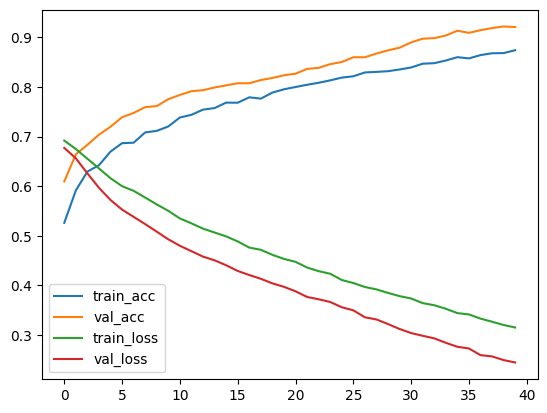

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy: 0.9209
MCC: 0.8416
AUC: 0.9692
AUPRC: 0.9677
Precision: 0.9339
Recall: 0.9150
Specificity: 0.9274
F1 Score: 0.9243
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy: 0.8025
MCC: 0.3587
AUC: 0.8581
AUPRC: 0.3146
Precision: 0.2506
Recall: 0.7628
Specificity: 0.8059
F1 Score: 0.3773


(0.8025418474891507,
 0.35870021963442994,
 0.8580565006002641,
 0.3146039021061449,
 0.2506493506493506,
 0.7628458498023716,
 0.8059199461823074,
 0.37732160312805474)

In [6]:
def build_simple_model(input_shape_conv, input_shape_ann):
    # Conv1D branch for sequence data
    conv_input = Input(shape=input_shape_conv)
    x_conv = Embedding(input_dim=64, output_dim=21)(conv_input)
    x_conv = Conv1D(32, kernel_size=3, activation='relu', padding='same')(x_conv)
    x_conv = MaxPooling1D(pool_size=2)(x_conv)
    x_conv = Conv1D(64, kernel_size=3, activation='relu', padding='same')(x_conv)
    x_conv = MaxPooling1D(pool_size=2)(x_conv)
    x_conv = Flatten()(x_conv)

    # Dense layer for sequence features
    x_conv = Dense(32, activation='relu')(x_conv)
    x_conv = Dropout(0.3)(x_conv)

    # ANN branch for prot_t5 embeddings
    ann_input = Input(shape=(input_shape_ann,))
    x_ann = Dense(32, activation='relu')(ann_input)
    x_ann = Dropout(0.3)(x_ann)

    # Concatenate Conv1D and ANN branches
    combined = Concatenate()([x_conv, x_ann])

    # Output layer
    x = Dense(32, activation='relu')(combined)
    x = Dropout(0.3)(x)
    output_layer = Dense(1, activation='sigmoid')(x)

    # Build model
    model = Model(inputs=[conv_input, ann_input], outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss=BinaryCrossentropy(),
                  metrics=['accuracy'])

    return model




set_seed(4)

# Define the model with Conv1D input shape (33,) and ANN input shape 1024
simple_model = build_simple_model((33,), 1024)
simple_model.summary()

# visualkeras.layered_view(simple_model, legend=True, ).show()

# Fit the Simple model
history = simple_model.fit([X_train_num, X_train_embeddings], y_train, epochs=40, batch_size=64, verbose=1,
                               validation_data=([X_val_num, X_val_embeddings], y_val),
                            )

plot(history)

evaluate_model(simple_model, X_val_num, X_val_embeddings, X_val_PSSM= None, y_val=y_val)
evaluate_model(simple_model, X_test_num, X_test_embeddings, X_val_PSSM= None, y_val=y_test)

InceptLysEmbed Model:

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 33)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 33, 21)    │      1,344 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 33, 21)    │          0 │ embedding_1[0][0] │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 33, 32)    │        704 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 33, 32)    │      2,048 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 33, 32)    │      3,392 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 33, 32)    │      4,736 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 33, 32)    │      6,080 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 33, 32)    │      7,424 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 33, 32)    │        704 │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 33, 224)   │          0 │ conv1d_2[0][0],   │
│ (Concatenate)       │                   │            │ conv1d_3[0][0],   │
│                     │                   │            │ conv1d_4[0][0],   │
│                     │                   │            │ conv1d_5[0][0],   │
│                     │                   │            │ conv1d_6[0][0],   │
│                     │                   │            │ conv1d_7[0][0],   │
│                     │                   │            │ conv1d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 16, 224)   │          0 │ concatenate_1[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 3584)      │          0 │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 1024)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 32)        │    114,720 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 32)        │     32,800 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 32)        │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 64)        │          0 │ dropout_3[0][0],  │
│ (Concatenate)       │                   │            │ dropout_4[0][0] 

 Total params: 176,065 (687.75 KB)

 Trainable params: 176,065 (687.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5112 - loss: 0.6955 - val_accuracy: 0.6310 - val_loss: 0.6762
Epoch 2/40
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5873 - loss: 0.6750 - val_accuracy: 0.6706 - val_loss: 0.6499
Epoch 3/40
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6168 - loss: 0.6545 - val_accuracy: 0.7037 - val_loss: 0.6142
Epoch 4/40
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6611 - loss: 0.6265 - val_accuracy: 0.7198 - val_loss: 0.5768
Epoch 5/40
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6795 - loss: 0.6046 - val_accuracy: 0.7326 - val_loss: 0.5448
Epoch 6/40
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6989 - loss: 0.5760 - val_accuracy: 0.7572 - val_loss: 0.5199
Epoch 7/40
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7251 - loss: 0.5504 - val_accuracy: 0.7733 - val_loss: 0.5008
Epoch 8/40
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7333 - loss: 0.5438 - val_accuracy: 0.

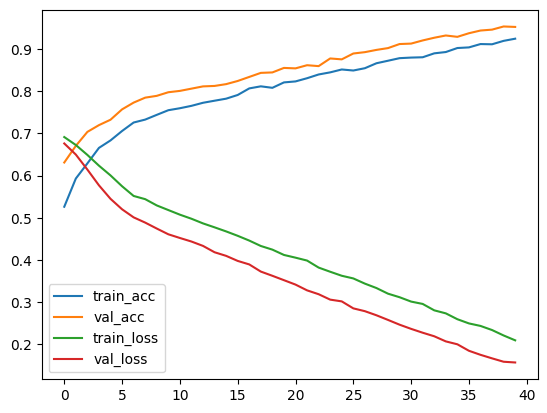

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Accuracy: 0.9529
MCC: 0.9073
AUC: 0.9913
AUPRC: 0.9914
Precision: 0.9808
Recall: 0.9291
Specificity: 0.9796
F1 Score: 0.9543
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.8165
MCC: 0.3623
AUC: 0.8609
AUPRC: 0.3006
Precision: 0.2616
Recall: 0.7352
Specificity: 0.8234
F1 Score: 0.3859


(0.8164910105393677,
 0.3622813343093845,
 0.8609388315657784,
 0.3006289377700532,
 0.2616033755274262,
 0.7351778656126482,
 0.8234106962663976,
 0.38589211618257263)

In [7]:
import tensorflow as tf
from keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Concatenate, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy

def inception_module(input_tensor):
    # Branch 1: Conv1D with kernel size 1
    branch1 = Conv1D(32, kernel_size=1, activation='relu', padding='same')(input_tensor)

    # Branch 2: Conv1D with kernel size 3
    branch2 = Conv1D(32, kernel_size=3, activation='relu', padding='same')(input_tensor)

    # Branch 3: Conv1D with kernel size 5
    branch3 = Conv1D(32, kernel_size=5, activation='relu', padding='same')(input_tensor)

    # Branch 4: Conv1D with kernel size 7
    branch4 = Conv1D(32, kernel_size=7, activation='relu', padding='same')(input_tensor)

    # Branch 5: Conv1D with kernel size 9
    branch5 = Conv1D(32, kernel_size=9, activation='relu', padding='same')(input_tensor)

    # Branch 6: Conv1D with kernel size 11
    branch6 = Conv1D(32, kernel_size=11, activation='relu', padding='same')(input_tensor)

    # Branch 6: MaxPooling + Conv1D with kernel size 1
    branch7 = MaxPooling1D(pool_size=2, strides=1, padding='same')(input_tensor)
    branch7 = Conv1D(32, kernel_size=1, activation='relu', padding='same')(branch7)


    # Concatenate all branches
    output = Concatenate()([branch1, branch2, branch3, branch4, branch5, branch6, branch7])
    return output

def build_inception_model(input_shape_conv, input_shape_ann):
    # Conv1D branch for sequence data
    conv_input = Input(shape=input_shape_conv)

    # Embedding layer
    x_conv = Embedding(input_dim=64, output_dim=21)(conv_input)

    # Apply Inception module instead of Conv1D
    x_conv = inception_module(x_conv)

    # MaxPooling and Flatten layers
    x_conv = MaxPooling1D(pool_size=2)(x_conv)
    x_conv = Flatten()(x_conv)

    # Dense layer for sequence features
    x_conv = Dense(32, activation='relu')(x_conv)
    x_conv = Dropout(0.3)(x_conv)

    # ANN branch for prot_t5 embeddings
    ann_input = Input(shape=(input_shape_ann,))

    # Simple Dense layer for ANN features
    x_ann = Dense(32, activation='relu')(ann_input)
    x_ann = Dropout(0.3)(x_ann)

    # Concatenate Conv1D (Inception) and ANN branches
    combined = Concatenate()([x_conv, x_ann])

    # Output layer
    x = Dense(32, activation='relu')(combined)
    x = Dropout(0.3)(x)
    output_layer = Dense(1, activation='sigmoid')(x)

    # Build model
    model = Model(inputs=[conv_input, ann_input], outputs=output_layer)

    # Compile model
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss=BinaryCrossentropy(),
                  metrics=['accuracy'])

    return model

set_seed(4)

# Define the model with Conv1D input shape (33,) and ANN input shape 1024
inception_model = build_inception_model((33,), 1024)
inception_model.summary()

# visualkeras.layered_view(inception_model, legend=True).show()

# Fit the Inception model
history = inception_model.fit([X_train_num, X_train_embeddings], y_train, epochs=40, batch_size=64, verbose=1,
                               validation_data=([X_val_num, X_val_embeddings], y_val),
                            )

plot(history)

evaluate_model(inception_model, X_val_num, X_val_embeddings, X_val_PSSM= None, y_val = y_val)
evaluate_model(inception_model, X_test_num, X_test_embeddings, X_val_PSSM= None, y_val = y_test)


ResLysEmbed Model :

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 33)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 33, 21)    │        441 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 33, 32)    │      2,048 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 33, 32)    │      3,104 │ conv1d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 33, 53)    │          0 │ conv1d_10[0][0],  │
│ (Concatenate)       │                   │            │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 16, 53)    │          0 │ concatenate_3[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 16, 64)    │     10,240 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 16, 64)    │     12,352 │ conv1d_11[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 16, 117)   │          0 │ conv1d_12[0][0],  │
│ (Concatenate)       │                   │            │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_5     │ (None, 8, 117)    │          0 │ concatenate_4[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 936)       │          0 │ max_pooling1d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 1024)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 32)        │     29,984 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 32)        │     32,800 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 32)        │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 32)        │          0 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 64)        │          0 │ dropout_6[0][0],  │
│ (Concatenate)       │                   │            │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 32)        │      2,080 │ concatenate_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 32)        │          0 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 1)         │         33 │ dropout_8[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 93,082 (363.60 KB)

 Trainable params: 93,082 (363.60 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4939 - loss: 0.6954 - val_accuracy: 0.5829 - val_loss: 0.6853
Epoch 2/40
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5682 - loss: 0.6829 - val_accuracy: 0.6278 - val_loss: 0.6679
Epoch 3/40
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6143 - loss: 0.6652 - val_accuracy: 0.6620 - val_loss: 0.6405
Epoch 4/40
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6333 - loss: 0.6469 - val_accuracy: 0.6824 - val_loss: 0.6128
Epoch 5/40
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6584 - loss: 0.6243 - val_accuracy: 0.7037 - val_loss: 0.5843
Epoch 6/40
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6797 - loss: 0.6013 - val_accuracy: 0.7337 - val_loss: 0.5502
Epoch 7/40
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7072 - loss: 0.5755 - val_accuracy: 0.7519 - val_loss: 0.5149
Epoch 8/40
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7186 - loss: 0.5522 - val_accuracy: 0.

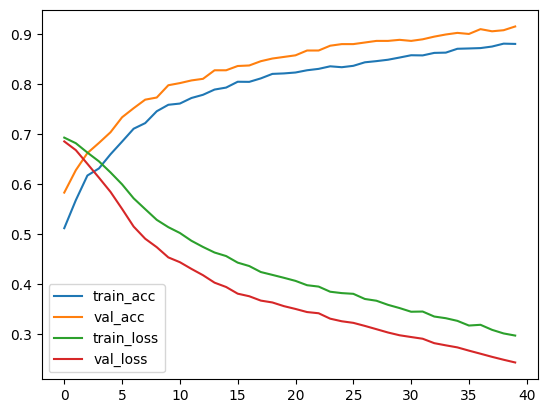

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Accuracy: 0.9155
MCC: 0.8304
AUC: 0.9660
AUPRC: 0.9634
Precision: 0.9158
Recall: 0.9251
Specificity: 0.9048
F1 Score: 0.9204
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.8053
MCC: 0.3893
AUC: 0.8733
AUPRC: 0.3482
Precision: 0.2624
Recall: 0.8182
Specificity: 0.8042
F1 Score: 0.3973


(0.8053316800991941,
 0.3892915359834252,
 0.8733004151992437,
 0.34815321450987313,
 0.2623574144486692,
 0.8181818181818182,
 0.8042381432896064,
 0.39731285988483683)

In [8]:
import tensorflow as tf
from keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Concatenate, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.initializers import Constant


def residual_block(input_tensor, filters):
    x = Conv1D(filters, kernel_size=3, activation='relu', padding='same')(input_tensor)
    x = Conv1D(filters, kernel_size=3, activation='relu', padding='same')(x)    
    x = Concatenate()([x, input_tensor])  # Skip connection
    return x

def build_resnet_model(input_shape_conv, input_shape_ann):
    # Conv1D branch for sequence data
    conv_input = Input(shape=input_shape_conv)
    x_conv = Embedding(input_dim=21, output_dim=21, name='embedding', trainable=True)(conv_input)

    # Apply Residual blocks
    x_conv = residual_block(x_conv, 32)
    x_conv = MaxPooling1D(pool_size=2)(x_conv)
    x_conv = residual_block(x_conv, 64)
    x_conv = MaxPooling1D(pool_size=2)(x_conv)
    x_conv = Flatten()(x_conv)

    # Dense layer for sequence features
    x_conv = Dense(32, activation='relu')(x_conv)
    x_conv = Dropout(0.3)(x_conv)

    # ANN branch for prot_t5 embeddings
    ann_input = Input(shape=(input_shape_ann,))
    x_ann = Dense(32, activation='relu')(ann_input)
    x_ann = Dropout(0.3)(x_ann)

    # Concatenate Conv1D (ResNet) and ANN branches
    combined = Concatenate()([x_conv, x_ann])

    # Output layer
    x = Dense(32, activation='relu')(combined)
    x = Dropout(0.3)(x)
    output_layer = Dense(1, activation='sigmoid')(x)

    # Build model
    model = Model(inputs=[conv_input, ann_input], outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss=BinaryCrossentropy(),
                  metrics=['accuracy'])

    return model


set_seed(4)

# Define the model with Conv1D input shape (33,) and ANN input shape 1024
res_model = build_resnet_model((33,), 1024)
res_model.summary()

# visualkeras.layered_view(res_model, legend=True).show()

# Fit the Inception model
history = res_model.fit([X_train_num, X_train_embeddings], y_train, epochs=40, batch_size=64, verbose=1,
                               validation_data=([X_val_num, X_val_embeddings], y_val),
                            )

plot(history)

evaluate_model(res_model, X_val_num, X_val_embeddings, X_val_PSSM= None, y_val = y_val)
evaluate_model(res_model, X_test_num, X_test_embeddings, X_val_PSSM= None, y_val = y_test)


ResLysEmbed with brunches trained seperately:

In [19]:
import tensorflow as tf
from keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Concatenate, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy

def residual_block(input_tensor, filters):
    x = Conv1D(filters, kernel_size=3, activation='relu', padding='same')(input_tensor)
    x = Conv1D(filters, kernel_size=3, activation='relu', padding='same')(x)    
    x = Concatenate()([x, input_tensor])  # Skip connection
    return x

def build_conv1d_branch(input_shape_conv):
    conv_input = Input(shape=input_shape_conv)
    x_conv = Embedding(input_dim=21, output_dim=21)(conv_input)

    x_conv = residual_block(x_conv, 32)
    x_conv = MaxPooling1D(pool_size=2)(x_conv)
    x_conv = residual_block(x_conv, 64)
    x_conv = MaxPooling1D(pool_size=2)(x_conv)
    x_conv = Flatten()(x_conv)

    x_conv = Dense(32, activation='relu', name = 'conv_output')(x_conv)
    x_conv = Dropout(0.3)(x_conv)

    x_conv = Dense(1, activation='sigmoid')(x_conv)

    model = Model(inputs=conv_input, outputs=x_conv)
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss=BinaryCrossentropy(),
                  metrics=['accuracy'])
    return model


def build_ann_branch(input_shape_ann):
    ann_input = Input(shape=(input_shape_ann,))
    x_ann = Dense(32, activation='relu', name = 'ann_output')(ann_input)
    x_ann = Dropout(0.3)(x_ann)

    x_ann = Dense(1, activation='sigmoid')(x_ann)

    model = Model(inputs=ann_input, outputs=x_ann)
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss=BinaryCrossentropy(),
                  metrics=['accuracy'])
    return model

conv1d_model = build_conv1d_branch((33,))

# Train Conv1D branch
history_conv = conv1d_model.fit(X_train_num, y_train, epochs=40, batch_size=64, validation_data=(X_val_num, y_val), verbose=0)

# Save the weights of Conv1D branch
conv1d_model.save_weights('Brunch train/conv1d.weights.h5')

ann_model = build_ann_branch(1024)

# Train ANN branch
history_ann = ann_model.fit(X_train_embeddings, y_train, epochs=40, batch_size=64, validation_data=(X_val_embeddings, y_val), verbose=0)

# Save the weights of ANN branch
ann_model.save_weights('Brunch train/ann.weights.h5')

def build_combined_model(conv1d_model, ann_model):
    # Load the weights of the Conv1D branch
    conv1d_model.load_weights('Brunch train/conv1d.weights.h5')

    # Load the weights of the ANN branch
    ann_model.load_weights('Brunch train/ann.weights.h5')

    conv1d_model.trainable = False
    ann_model.trainable = False

    # Get the output tensors of the Conv1D and ANN branches
    conv_output = conv1d_model.get_layer('conv_output').output
    ann_output = ann_model.get_layer('ann_output').output

    # Concatenate the output tensors
    combined = Concatenate()([conv_output, ann_output])

    # Output layer
    x = Dense(32, activation='relu')(combined)
    x = Dropout(0.3)(x)
    output_layer = Dense(1, activation='sigmoid')(x)

    # Build the combined model
    model = Model(inputs=[conv1d_model.input, ann_model.input], outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss=BinaryCrossentropy(),
                  metrics=['accuracy'])
    return model

set_seed(4)

# Build the combined model
combined_model = build_combined_model(conv1d_model, ann_model)

# Fit the combined model
history = combined_model.fit([X_train_num, X_train_embeddings], y_train, epochs=40, batch_size=64, verbose=0,
                             validation_data=([X_val_num, X_val_embeddings], y_val))


evaluate_model(combined_model, X_val_num, X_val_embeddings, X_val_PSSM= None, y_val = y_val)
evaluate_model(combined_model, X_test_num, X_test_embeddings, X_val_PSSM= None, y_val = y_test)

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Accuracy: 0.7936
MCC: 0.5880
AUC: 0.8735
AUPRC: 0.8568
Precision: 0.7785
Recall: 0.8201
Specificity: 0.7671
F1 Score: 0.7987
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.7793
MCC: 0.3576
AUC: 0.8625
AUPRC: 0.3287
Precision: 0.2365
Recall: 0.8142
Specificity: 0.7763
F1 Score: 0.3665


(0.7792932424054557,
 0.3576098412228621,
 0.8625023099861866,
 0.3287340543936059,
 0.2365097588978186,
 0.8142292490118577,
 0.7763202152707702,
 0.3665480427046263)

Simple + PSSM model:

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 33)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_7         │ (None, 33, 21)    │      1,344 │ input_layer_14[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_33 (Conv1D)  │ (None, 33, 32)    │      2,048 │ embedding_7[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_14    │ (None, 16, 32)    │          0 │ conv1d_33[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_34 (Conv1D)  │ (None, 16, 64)    │      6,208 │ max_pooling1d_14… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_15    │ (None, 8, 64)     │          0 │ conv1d_34[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_7 (Flatten) │ (None, 512)       │          0 │ max_pooling1d_15… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_15      │ (None, 1024)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_16      │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 32)        │     16,416 │ flatten_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_29 (Dense)    │ (None, 32)        │     32,800 │ input_layer_15[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 16)        │        336 │ input_layer_16[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 32)        │          0 │ dense_28[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_22          │ (None, 32)        │          0 │ dense_29[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_23          │ (None, 16)        │          0 │ dense_30[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_14      │ (None, 80)        │          0 │ dropout_21[0][0], │
│ (Concatenate)       │                   │            │ dropout_22[0][0], │
│                     │                   │            │ dropout_23[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_31 (Dense)    │ (None, 32)        │      2,592 │ concatenate_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_24          │ (None, 32)        │          0 │ dense_31[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_32 (Dense)    │ (None, 1)         │         33 │ dropout_24[0][0]

 Total params: 61,777 (241.32 KB)

 Trainable params: 61,777 (241.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5010 - loss: 0.7126 - val_accuracy: 0.5476 - val_loss: 0.6855
Epoch 2/40
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5398 - loss: 0.6904 - val_accuracy: 0.6139 - val_loss: 0.6685
Epoch 3/40
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5828 - loss: 0.6778 - val_accuracy: 0.6578 - val_loss: 0.6494
Epoch 4/40
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6088 - loss: 0.6607 - val_accuracy: 0.6845 - val_loss: 0.6270
Epoch 5/40
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6391 - loss: 0.6403 - val_accuracy: 0.7112 - val_loss: 0.6043
Epoch 6/40
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6556 - loss: 0.6250 - val_accuracy: 0.7230 - val_loss: 0.5819
Epoch 7/40
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6676 - loss: 0.6147 - val_accuracy: 0.7380 - val_loss: 0.5642
Epoch 8/40
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6694 - loss: 0.6041 - val_accuracy: 0.

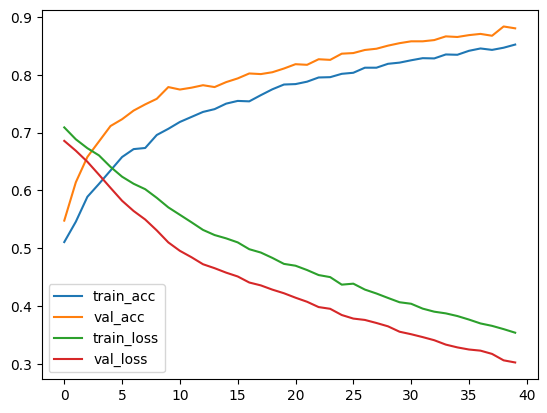

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy: 0.8802
MCC: 0.7599
AUC: 0.8802
AUPRC: 0.9455
Precision: 0.8914
Recall: 0.8806
Specificity: 0.8798
F1 Score: 0.8859
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy: 0.7998
MCC: 0.3554
AUC: 0.7829
AUPRC: 0.3309
Precision: 0.2478
Recall: 0.7628
Specificity: 0.8029
F1 Score: 0.3740


(0.7997520148791073,
 0.3553757385756881,
 0.7828692753889086,
 0.3308817607058337,
 0.24775353016688062,
 0.7628458498023716,
 0.8028927009754456,
 0.374031007751938)

In [16]:
def build_simple_pssm_model(input_shape_conv, input_shape_ann, input_shape_pssm):
    # Conv1D branch for sequence data
    conv_input = Input(shape=input_shape_conv)
    x_conv = Embedding(input_dim=64, output_dim=21)(conv_input)
    x_conv = Conv1D(32, kernel_size=3, activation='relu', padding='same')(x_conv)
    x_conv = MaxPooling1D(pool_size=2)(x_conv)
    x_conv = Conv1D(64, kernel_size=3, activation='relu', padding='same')(x_conv)
    x_conv = MaxPooling1D(pool_size=2)(x_conv)
    x_conv = Flatten()(x_conv)

    # Dense layer for sequence features
    x_conv = Dense(32, activation='relu')(x_conv)
    x_conv = Dropout(0.3)(x_conv)

    # ANN branch for prot_t5 embeddings
    ann_input = Input(shape=(input_shape_ann,))
    x_ann = Dense(32, activation='relu')(ann_input)
    x_ann = Dropout(0.3)(x_ann)

    # PSSM branch
    pssm_input = Input(shape=(input_shape_pssm,))
    x_pssm = Dense(16, activation='relu')(pssm_input)
    x_pssm = Dropout(0.3)(x_pssm)

    # Concatenate Conv1D and ANN branches
    combined = Concatenate()([x_conv, x_ann, x_pssm])

    # Output layer
    x = Dense(32, activation='relu')(combined)
    x = Dropout(0.3)(x)
    output_layer = Dense(1, activation='sigmoid')(x)

    # Build model
    model = Model(inputs=[conv_input, ann_input, pssm_input], outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss=BinaryCrossentropy(),
                  metrics=['accuracy'])

    return model




set_seed(4)

# Define the model with Conv1D input shape (33,) and ANN input shape 1024
simple_pssm_model = build_simple_pssm_model((33,), 1024, 20)
simple_pssm_model.summary()

# Fit the Inception model
history = simple_pssm_model.fit([X_train_num, X_train_embeddings, X_train_PSSM], y_train, epochs=40, batch_size=64, verbose=1,
                                 validation_data=([X_val_num, X_val_embeddings, X_val_PSSM], y_val),
                            )

plot(history)

evaluate_model(simple_pssm_model, X_val_num, X_val_embeddings, X_val_PSSM, y_val)
evaluate_model(simple_pssm_model, X_test_num, X_test_embeddings, X_test_PSSM, y_test)

Inception+PSSM model:

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17      │ (None, 33)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_8         │ (None, 33, 21)    │      1,344 │ input_layer_17[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_16    │ (None, 33, 21)    │          0 │ embedding_8[0][0] │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_35 (Conv1D)  │ (None, 33, 32)    │        704 │ embedding_8[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_36 (Conv1D)  │ (None, 33, 32)    │      2,048 │ embedding_8[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_37 (Conv1D)  │ (None, 33, 32)    │      3,392 │ embedding_8[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_38 (Conv1D)  │ (None, 33, 32)    │      4,736 │ embedding_8[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_39 (Conv1D)  │ (None, 33, 32)    │      6,080 │ embedding_8[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_40 (Conv1D)  │ (None, 33, 32)    │        704 │ max_pooling1d_16… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_15      │ (None, 33, 192)   │          0 │ conv1d_35[0][0],  │
│ (Concatenate)       │                   │            │ conv1d_36[0][0],  │
│                     │                   │            │ conv1d_37[0][0],  │
│                     │                   │            │ conv1d_38[0][0],  │
│                     │                   │            │ conv1d_39[0][0],  │
│                     │                   │            │ conv1d_40[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_17    │ (None, 16, 192)   │          0 │ concatenate_15[0… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_8 (Flatten) │ (None, 3072)      │          0 │ max_pooling1d_17… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_18      │ (None, 1024)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_19      │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_33 (Dense)    │ (None, 32)        │     98,336 │ flatten_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_34 (Dense)    │ (None, 32)        │     32,800 │ input_layer_18[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_35 (Dense)    │ (None, 16)        │        336 │ input_layer_19[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_25          │ (None, 32)        │          0 │ dense_33[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_26          │ (None, 32)        │          0 │ dense_34[0][0]  

 Total params: 153,105 (598.07 KB)

 Trainable params: 153,105 (598.07 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.4955 - loss: 0.7279 - val_accuracy: 0.5444 - val_loss: 0.6885
Epoch 2/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5194 - loss: 0.6954 - val_accuracy: 0.5979 - val_loss: 0.6745
Epoch 3/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5619 - loss: 0.6778 - val_accuracy: 0.6674 - val_loss: 0.6497
Epoch 4/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6103 - loss: 0.6556 - val_accuracy: 0.7016 - val_loss: 0.6174
Epoch 5/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6512 - loss: 0.6314 - val_accuracy: 0.7048 - val_loss: 0.5836
Epoch 6/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6727 - loss: 0.6080 - val_accuracy: 0.7316 - val_loss: 0.5524
Epoch 7/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6969 - loss: 0.5816 - val_accuracy: 0.7497 - val_loss: 0.5289
Epoch 8/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7138 - loss: 0.5661 - val_accuracy: 0.

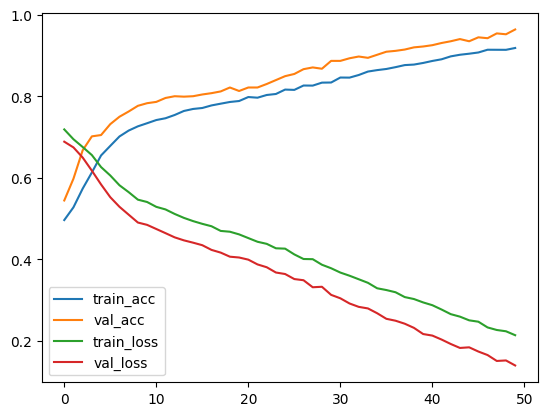

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Accuracy: 0.9636
MCC: 0.9272
AUC: 0.9639
AUPRC: 0.9924
Precision: 0.9713
Recall: 0.9595
Specificity: 0.9683
F1 Score: 0.9654
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.7870
MCC: 0.3310
AUC: 0.7669
AUPRC: 0.2764
Precision: 0.2321
Recall: 0.7431
Specificity: 0.7908
F1 Score: 0.3537


(0.787042777433354,
 0.33097835483001586,
 0.766933362050284,
 0.2764289711226823,
 0.23209876543209876,
 0.7430830039525692,
 0.7907837201479987,
 0.35371589840075257)

In [17]:
import tensorflow as tf
from keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Concatenate, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy

def inception_module(input_tensor):
    # Branch 1: Conv1D with kernel size 1
    branch1 = Conv1D(32, kernel_size=1, activation='relu', padding='same')(input_tensor)

    # Branch 2: Conv1D with kernel size 3
    branch2 = Conv1D(32, kernel_size=3, activation='relu', padding='same')(input_tensor)

    # Branch 3: Conv1D with kernel size 5
    branch3 = Conv1D(32, kernel_size=5, activation='relu', padding='same')(input_tensor)

    # Branch 4: Conv1D with kernel size 7
    branch4 = Conv1D(32, kernel_size=7, activation='relu', padding='same')(input_tensor)

    # Branch 5: Conv1D with kernel size 9
    branch5 = Conv1D(32, kernel_size=9, activation='relu', padding='same')(input_tensor)

    # Branch 6: MaxPooling + Conv1D with kernel size 1
    branch6 = MaxPooling1D(pool_size=3, strides=1, padding='same')(input_tensor)
    branch6 = Conv1D(32, kernel_size=1, activation='relu', padding='same')(branch6)


    # Concatenate all branches
    output = Concatenate()([branch1, branch2, branch3, branch4, branch5, branch6])
    return output

def build_inception_pssm_model(input_shape_conv, input_shape_ann, input_shape_pssm):
    # Conv1D branch for sequence data
    conv_input = Input(shape=input_shape_conv)

    # Embedding layer
    x_conv = Embedding(input_dim=64, output_dim=21)(conv_input)

    # Apply Inception module instead of Conv1D
    x_conv = inception_module(x_conv)

    # MaxPooling and Flatten layers
    x_conv = MaxPooling1D(pool_size=2)(x_conv)
    x_conv = Flatten()(x_conv)

    # Dense layer for sequence features
    x_conv = Dense(32, activation='relu')(x_conv)
    x_conv = Dropout(0.3)(x_conv)

    # ANN branch for prot_t5 embeddings
    ann_input = Input(shape=(input_shape_ann,))

    # Simple Dense layer for ANN features
    x_ann = Dense(32, activation='relu')(ann_input)
    x_ann = Dropout(0.3)(x_ann)

    # PSSM branch
    pssm_input = Input(shape=(input_shape_pssm,))

    # Simple Dense layer for PSSM features
    x_pssm = Dense(16, activation='relu')(pssm_input)
    x_pssm = Dropout(0.3)(x_pssm)

    # Concatenate Conv1D (Inception) and ANN branches
    combined = Concatenate()([x_conv, x_ann, x_pssm])

    # Output layer
    x = Dense(32, activation='relu')(combined)
    x = Dropout(0.3)(x)
    output_layer = Dense(1, activation='sigmoid')(x)

    # Build model
    model = Model(inputs=[conv_input, ann_input, pssm_input], outputs=output_layer)

    # Compile model
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss=BinaryCrossentropy(),
                  metrics=['accuracy'])

    return model

set_seed(4)

# Define the model with Conv1D input shape (33,) and ANN input shape 1024
inception_pssm_model = build_inception_pssm_model((33,), 1024, 20)
inception_pssm_model.summary()


# Fit the Inception model
history = inception_pssm_model.fit([X_train_num, X_train_embeddings, X_train_PSSM], y_train, epochs=50, batch_size=64, verbose=1,
                                 validation_data=([X_val_num, X_val_embeddings, X_val_PSSM], y_val),
                             )

plot(history)

evaluate_model(inception_pssm_model, X_val_num, X_val_embeddings, X_val_PSSM= X_val_PSSM, y_val = y_val)
evaluate_model(inception_pssm_model, X_test_num, X_test_embeddings, X_val_PSSM= X_test_PSSM, y_val = y_test)


Resnet+PSSM model:

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20      │ (None, 33)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_9         │ (None, 33, 21)    │        441 │ input_layer_20[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_41 (Conv1D)  │ (None, 33, 32)    │      2,048 │ embedding_9[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_42 (Conv1D)  │ (None, 33, 32)    │      3,104 │ conv1d_41[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_17      │ (None, 33, 53)    │          0 │ conv1d_42[0][0],  │
│ (Concatenate)       │                   │            │ embedding_9[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_18    │ (None, 16, 53)    │          0 │ concatenate_17[0… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_43 (Conv1D)  │ (None, 16, 64)    │     10,240 │ max_pooling1d_18… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_44 (Conv1D)  │ (None, 16, 64)    │     12,352 │ conv1d_43[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_18      │ (None, 16, 117)   │          0 │ conv1d_44[0][0],  │
│ (Concatenate)       │                   │            │ max_pooling1d_18… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_19    │ (None, 8, 117)    │          0 │ concatenate_18[0… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_9 (Flatten) │ (None, 936)       │          0 │ max_pooling1d_19… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_21      │ (None, 1024)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_22      │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_38 (Dense)    │ (None, 32)        │     29,984 │ flatten_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_39 (Dense)    │ (None, 32)        │     32,800 │ input_layer_21[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_40 (Dense)    │ (None, 16)        │        336 │ input_layer_22[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_29          │ (None, 32)        │          0 │ dense_38[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_30          │ (None, 32)        │          0 │ dense_39[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_31          │ (None, 16)        │          0 │ dense_40[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 93,930 (366.91 KB)

 Trainable params: 93,930 (366.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5076 - loss: 0.7264 - val_accuracy: 0.6000 - val_loss: 0.6732
Epoch 2/40
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5519 - loss: 0.6873 - val_accuracy: 0.6299 - val_loss: 0.6540
Epoch 3/40
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5987 - loss: 0.6657 - val_accuracy: 0.6706 - val_loss: 0.6287
Epoch 4/40
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6237 - loss: 0.6464 - val_accuracy: 0.7123 - val_loss: 0.6033
Epoch 5/40
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6509 - loss: 0.6266 - val_accuracy: 0.7251 - val_loss: 0.5796
Epoch 6/40
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6674 - loss: 0.6112 - val_accuracy: 0.7465 - val_loss: 0.5562
Epoch 7/40
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6898 - loss: 0.5885 - val_accuracy: 0.7668 - val_loss: 0.5246
Epoch 8/40
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7132 - loss: 0.5629 - val_accuracy: 0.

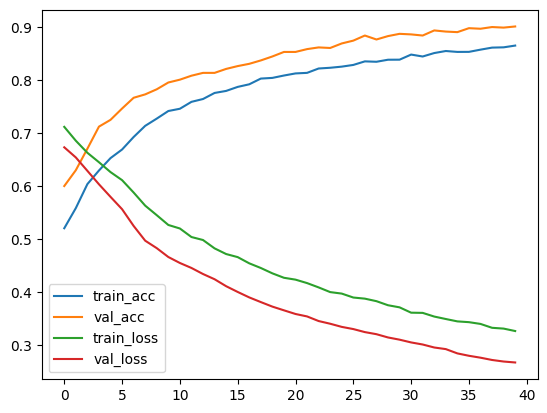

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Accuracy: 0.9016
MCC: 0.8025
AUC: 0.9009
AUPRC: 0.9490
Precision: 0.9020
Recall: 0.9130
Specificity: 0.8889
F1 Score: 0.9074
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.7991
MCC: 0.3857
AUC: 0.8115
AUPRC: 0.3269
Precision: 0.2571
Recall: 0.8261
Specificity: 0.7968
F1 Score: 0.3921


(0.7991320520768754,
 0.38571778025183007,
 0.8114625835417308,
 0.32693826030537454,
 0.2570725707257073,
 0.8260869565217391,
 0.7968382105617222,
 0.3921200750469043)

In [18]:
import tensorflow as tf
from keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Concatenate
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy

def residual_block(input_tensor, filters):
    x = Conv1D(filters, kernel_size=3, activation='relu', padding='same')(input_tensor)
    x = Conv1D(filters, kernel_size=3, activation='relu', padding='same')(x)
    x = Concatenate()([x, input_tensor])  # Skip connection
    return x

def build_resnet_pssm_model(input_shape_conv, input_shape_ann, input_shape_pssm):
    # Conv1D branch for sequence data
    conv_input = Input(shape=input_shape_conv)
    x_conv = Embedding(input_dim=21, output_dim=21)(conv_input)

    # Apply Residual blocks
    x_conv = residual_block(x_conv, 32)
    x_conv = MaxPooling1D(pool_size=2)(x_conv)
    x_conv = residual_block(x_conv, 64)
    x_conv = MaxPooling1D(pool_size=2)(x_conv)
    x_conv = Flatten()(x_conv)

    # Dense layer for sequence features
    x_conv = Dense(32, activation='relu')(x_conv)
    x_conv = Dropout(0.3)(x_conv)

    # ANN branch for prot_t5 embeddings
    ann_input = Input(shape=(input_shape_ann,))
    pssm_input = Input(shape=(input_shape_pssm,))

    x_ann = Dense(32, activation='relu')(ann_input)
    x_ann = Dropout(0.3)(x_ann)

    # PSSM branch
    x_pssm = Dense(16, activation='relu')(pssm_input)
    x_pssm = Dropout(0.3)(x_pssm)

    # Concatenate Conv1D (ResNet), ANN, and PSSM branches
    combined = Concatenate()([x_conv, x_ann, x_pssm])

    # Output layer
    x = Dense(32, activation='relu')(combined)
    x = Dropout(0.3)(x)
    output_layer = Dense(1, activation='sigmoid')(x)

    # Build model
    model = Model(inputs=[conv_input, ann_input, pssm_input], outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss=BinaryCrossentropy(),
                  metrics=['accuracy'])

    return model

set_seed(4)

# Define the model with Conv1D input shape (33,), ANN input shape 1024, and PSSM input shape 20
res_pssm_model = build_resnet_pssm_model((33,), 1024, 20)
res_pssm_model.summary()

# Fit the model with PSSM included
history = res_pssm_model.fit([X_train_num, X_train_embeddings, X_train_PSSM], y_train, epochs=40, batch_size=64, verbose=1,
                               validation_data=([X_val_num, X_val_embeddings, X_val_PSSM], y_val),
                            )

plot(history)

evaluate_model(res_pssm_model, X_val_num, X_val_embeddings, X_val_PSSM, y_val)
evaluate_model(res_pssm_model, X_test_num, X_test_embeddings, X_test_PSSM, y_test)


Save and Load the models :

In [19]:
simple_model.save('Thesis-Results/Models/Full Models/simple_model.h5')
inception_model.save('Thesis-Results/Models/Full Models/inception_model.h5')
res_model.save('Thesis-Results/Models/Full Models/res_model.h5')
simple_pssm_model.save('Thesis-Results/Models/Full Models/simple_pssm_model.h5')
inception_pssm_model.save('Thesis-Results/Models/Full Models/inception_pssm_model.h5')
res_pssm_model.save('Thesis-Results/Models/Full Models/res_pssm_model.h5')

simple_model.save_weights('Thesis-Results/Models/Weights/simple_model.weights.h5')
inception_model.save_weights('Thesis-Results/Models/Weights/inception_model.weights.h5')
res_model.save_weights('Thesis-Results/Models/Weights/res_model.weights.h5')
simple_pssm_model.save_weights('Thesis-Results/Models/Weights/simple_pssm_model.weights.h5')
inception_pssm_model.save_weights('Thesis-Results/Models/Weights/inception_pssm_model.weights.h5')
res_pssm_model.save_weights('Thesis-Results/Models/Weights/res_pssm_model.weights.h5')

In [7]:
#Load the models and evaluate them
from keras.models import load_model

# simple_model = build_simple_model((33,), 1024)
# simple_model.load_weights('Thesis-Results/Models/Weights/simple_model.weights.h5')

# inception_model = build_inception_model((33,), 1024)
# inception_model.load_weights('Thesis-Results/Models/Weights/inception_model.weights.h5')

# res_model = build_resnet_model((33,), 1024)
# res_model.load_weights('Thesis-Results/Models/Weights/res_model.weights.h5')

# simple_pssm_model = build_simple_pssm_model((33,), 1024, 20)
# simple_pssm_model.load_weights('Thesis-Results/Models/Weights/simple_pssm_model.weights.h5')

# inception_pssm_model = build_inception_pssm_model((33,), 1024, 20)
# inception_pssm_model.load_weights('Thesis-Results/Models/Weights/inception_pssm_model.weights.h5')

# res_pssm_model = build_resnet_pssm_model((33,), 1024, 20)
# res_pssm_model.load_weights('Thesis-Results/Models/Weights/res_pssm_model.weights.h5')

simple_model = load_model('Thesis-Results/Models/Full Models/simple_model.h5')
inception_model = load_model('Thesis-Results/Models/Full Models/inception_model.h5')
res_model = load_model('Thesis-Results/Models/Full Models/res_model.h5')
simple_pssm_model = load_model('Thesis-Results/Models/Full Models/simple_pssm_model.h5')
inception_pssm_model = load_model('Thesis-Results/Models/Full Models/inception_pssm_model.h5')
res_pssm_model = load_model('Thesis-Results/Models/Full Models/res_pssm_model.h5')

print("Simple Model:")
evaluate_model(simple_model, X_test_num, X_test_embeddings, X_val_PSSM= None, y_val = y_test)
print("Inception Model:")
evaluate_model(inception_model, X_test_num, X_test_embeddings, X_val_PSSM= None, y_val = y_test)
print("Residual Model:")
evaluate_model(res_model, X_test_num, X_test_embeddings, X_val_PSSM= None, y_val = y_test)
print("Simple Model with PSSM:")
evaluate_model(simple_pssm_model, X_test_num, X_test_embeddings, X_test_PSSM, y_test)
print("Inception Model with PSSM:")
evaluate_model(inception_pssm_model, X_test_num, X_test_embeddings, X_test_PSSM, y_test)
print("Residual Model with PSSM:")
evaluate_model(res_pssm_model, X_test_num, X_test_embeddings, X_test_PSSM, y_test)

Simple Model:
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.8025
MCC: 0.3587
AUC: 0.8581
AUPRC: 0.3146
Precision: 0.2506
Recall: 0.7628
Specificity: 0.8059
F1 Score: 0.3773
Inception Model:
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Accuracy: 0.8165
MCC: 0.3623
AUC: 0.8609
AUPRC: 0.3006
Precision: 0.2616
Recall: 0.7352
Specificity: 0.8234
F1 Score: 0.3859
Residual Model:
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy: 0.8053
MCC: 0.3893
AUC: 0.8733
AUPRC: 0.3482
Precision: 0.2624
Recall: 0.8182
Specificity: 0.8042
F1 Score: 0.3973
Simple Model with PSSM:
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.7998
MCC: 0.3554
AUC: 0.8652
AUPRC: 0.3309
Precision: 0.2478
Recall: 0.7628
Specificity: 0.8029
F1 Score: 0.3740
Inception Model with PSSM:
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Accuracy: 0.7870
MCC: 0.3310
AUC: 0.8529
AUPRC: 0.2764
Precision: 0.2321
Recall: 0.7431
Specificity: 0.7908
F1 Score: 0.3537
Residual Model with PSSM:
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Accur

(0.7991320520768754,
 0.38571778025183007,
 0.875059328422203,
 0.32693826030537454,
 0.2570725707257073,
 0.8260869565217391,
 0.7968382105617222,
 0.3921200750469043)

Croos Validation:

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Results for res_model:
Accuracy: 0.7964859325081015 +- 0.013027444752855818
MCC: 0.5940958015013817 +- 0.027297546265819782
AUC: 0.7960043243580827 +- 0.013329202662324948
AUPRC: 0.8521055179203285 +- 0.0164745435153931

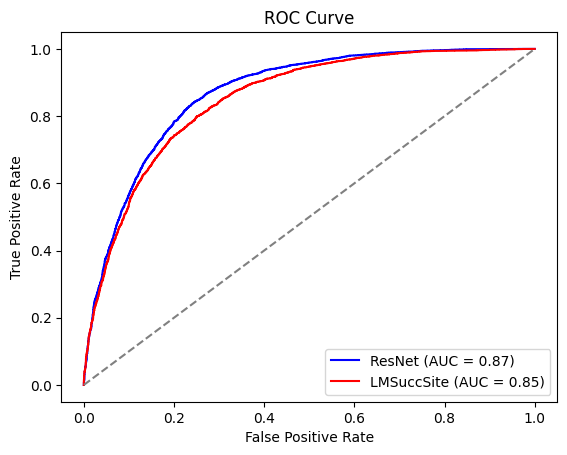

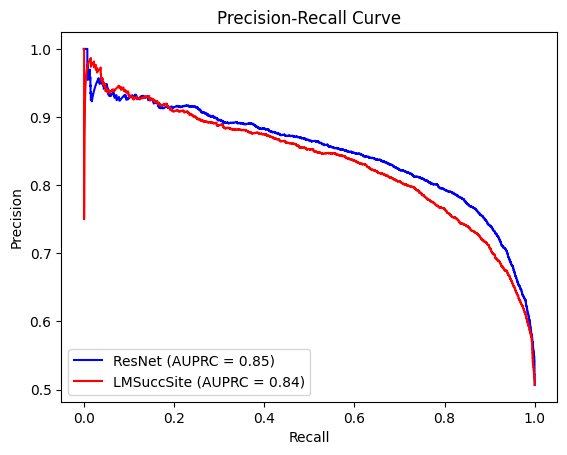

In [40]:
#croos validation
from sklearn.model_selection import KFold
import numpy as np

# Define the number of splits for cross-validation
n_splits = 10
kf = KFold(n_splits=n_splits, random_state=4, shuffle=True)


# Perform cross-validation in a function
def cross_validate_model(model_name, X, X_pt5, y, kf, X_PSSM = None):
    set_seed(4)

    # Initialize lists to store the results
    y_preds = []
    y_trues = []
    y_probs = []

    accuracies = []
    mccs = []
    aucs = []
    auprcs = []
    precisions = []
    recalls = []
    specificities = []
    f1s = []
    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        X_train_pt5, X_val_pt5 = X_pt5[train_index], X_pt5[val_index]
        y_train, y_val = y[train_index], y[val_index]
        if X_PSSM is not None:
            X_train_PSSM, X_val_PSSM = X_PSSM[train_index], X_PSSM[val_index]

        # reinitialize the model
        if model_name == 'inception_model':
            model = build_inception_model((33,), 1024)
        elif model_name == 'res_model':
            model = build_resnet_model((33,), 1024)
        elif model_name == 'simple_model':
            model = build_simple_model((33,), 1024)
        elif model_name == 'simple_pssm_model':
            model = build_simple_pssm_model((33,), 1024, 20)
        elif model_name == 'inception_pssm_model':
            model = build_inception_pssm_model((33,), 1024, 20)
        elif model_name == 'res_pssm_model':
            model = build_resnet_pssm_model((33,), 1024, 20)

        # Fit the model
        if X_PSSM is None:
            history = model.fit([X_train, X_train_pt5], y_train, epochs=40, batch_size=64, verbose=0,
                                validation_data=([X_val, X_val_pt5], y_val))
        else:
            history = model.fit([X_train, X_train_pt5, X_train_PSSM], y_train, epochs=40, batch_size=64, verbose=0,
                                validation_data=([X_val, X_val_pt5, X_val_PSSM], y_val))
                    
        y_true = y_val
        # Predict probabilities
        if X_PSSM is None:
            y_pred_probs = model.predict([X_val, X_val_pt5])
        else:
            y_pred_probs = model.predict([X_val, X_val_pt5, X_val_PSSM])

        # Convert probabilities to binary predictions
        y_pred = (y_pred_probs > 0.5).astype(int)

        # Append the results to the lists
        y_preds.append(y_pred)
        y_trues.append(y_true)
        y_probs.append(y_pred_probs)

        # Evaluate the model
        if X_PSSM is None:
            accuracy, mcc, auc, auprc, precision, recall, specificity, f1 = evaluate_model(model, X_val, X_val_pt5,
                                                                                            X_val_PSSM=None, y_val=y_val, print_metrics=False)
        else:
            accuracy, mcc, auc, auprc, precision, recall, specificity, f1 = evaluate_model(model, X_val, X_val_pt5,
                                                                                            X_val_PSSM, y_val, print_metrics=False)
        # Append the results to the lists
        accuracies.append(accuracy)
        mccs.append(mcc)
        aucs.append(auc)
        auprcs.append(auprc)
        precisions.append(precision)
        recalls.append(recall)
        specificities.append(specificity)
        f1s.append(f1)
    # Print the average results +- standard deviation
    print(f"Results for {model_name}:")
    print(f'Accuracy: {np.mean(accuracies)} +- {np.std(accuracies)}')
    print(f'MCC: {np.mean(mccs)} +- {np.std(mccs)}')
    print(f'AUC: {np.mean(aucs)} +- {np.std(aucs)}')
    print(f'AUPRC: {np.mean(auprcs)} +- {np.std(auprcs)}')
    print(f'Precision: {np.mean(precisions)} +- {np.std(precisions)}')
    print(f'Recall: {np.mean(recalls)} +- {np.std(recalls)}')
    print(f'Specificity: {np.mean(specificities)} +- {np.std(specificities)}')
    print(f'F1: {np.mean(f1s)} +- {np.std(f1s)}')

    # plot_roc_pr(model_name, np.concatenate(y_trues), np.concatenate(y_probs), aucs, auprcs)

    return np.concatenate(y_trues), np.concatenate(y_probs), aucs, auprcs

# Perform cross-validation for the 6 models
# cross_validate_model('simple_model', X_train_num, X_train_embeddings, y_train, kf)
# cross_validate_model('inception_model', X_train_num, X_train_embeddings, y_train, kf)
res_y_trues, res_y_probs, res_aucs, res_auprcs = cross_validate_model('res_model', X_train_num, X_train_embeddings, y_train, kf)
# cross_validate_model('simple_pssm_model', X_train_num, X_train_embeddings, y_train, kf, X_train_PSSM)
# cross_validate_model('inception_pssm_model', X_train_num, X_train_embeddings, y_train, kf, X_train_PSSM)
# res_pssm_y_trues, res_pssm_y_probs, res_pssm_aucs, res_pssm_auprcs = cross_validate_model('res_pssm_model', 
#                                                                                           X_train_num, X_train_embeddings, y_train, kf, X_train_PSSM)

LM_y_true_all = np.load('Thesis-Results/LM_y_true_all.npy')
LM_y_pred_all = np.load('Thesis-Results/LM_y_pred_all.npy')
LM_y_pred_proba_all = np.load('Thesis-Results/LM_y_pred_proba_all.npy')

# # Plot ROC and PR curves for all models in a single plot
from sklearn.metrics import roc_curve, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

fpr_res, tpr_res, _ = roc_curve(res_y_trues, res_y_probs)
# fpr_res_pssm, tpr_res_pssm, _ = roc_curve(res_pssm_y_trues, res_pssm_y_probs)
fpr_lm, tpr_lm, _ = roc_curve(LM_y_true_all, LM_y_pred_proba_all)
plt.figure()
plt.plot(fpr_res, tpr_res, color='blue', label='ResNet (AUC = %0.2f)' % roc_auc_score(res_y_trues, res_y_probs))
# plt.plot(fpr_res_pssm, tpr_res_pssm, color='green', label='ResNet + PSSM (AUC = %0.2f)' % roc_auc_score(res_pssm_y_trues, res_pssm_y_probs))
plt.plot(fpr_lm, tpr_lm, color='red', label='LMSuccSite (AUC = %0.2f)' % roc_auc_score(LM_y_true_all, LM_y_pred_proba_all))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.savefig('ROC_curve.pdf', format='pdf', bbox_inches='tight')
plt.show()

precision_res, recall_res, _ = precision_recall_curve(res_y_trues, res_y_probs)
# precision_res_pssm, recall_res_pssm, _ = precision_recall_curve(res_pssm_y_trues, res_pssm_y_probs)
precision_lm, recall_lm, _ = precision_recall_curve(LM_y_true_all, LM_y_pred_proba_all)
plt.figure()
plt.plot(recall_res, precision_res, color='blue', label='ResNet (AUPRC = %0.2f)' % average_precision_score(res_y_trues, res_y_probs))
# plt.plot(recall_res_pssm, precision_res_pssm, color='green', label='ResNet + PSSM (AUPRC = %0.2f)' % average_precision_score(res_pssm_y_trues, res_pssm_y_probs))
plt.plot(recall_lm, precision_lm, color='red', label='LMSuccSite (AUPRC = %0.2f)' % average_precision_score(LM_y_true_all, LM_y_pred_proba_all))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.savefig('PR_curve.pdf', format='pdf', bbox_inches='tight')

plt.show()



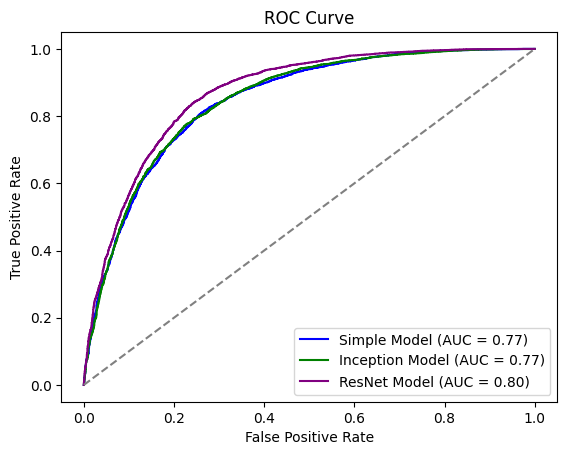

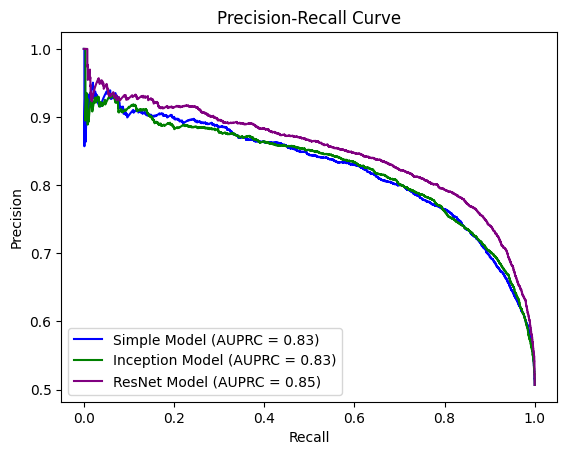

In [51]:
# simple_y_true, simple_y_pred, simple_aucs, simple_auprcs = cross_validate_model('simple_model', X_train_num, X_train_embeddings, y_train, kf)
# incept_y_true, incept_y_pred, incept_aucs, incept_auprcs = cross_validate_model('inception_model', X_train_num, X_train_embeddings, y_train, kf)
# res_y_true, res_y_pred, res_aucs, res_auprcs = cross_validate_model('res_model', X_train_num, X_train_embeddings, y_train, kf)
# simple_pssm_y_true, simple_pssm_y_pred, simple_pssm_aucs, simple_pssm_auprcs = cross_validate_model('simple_pssm_model', X_train_num, X_train_embeddings, y_train, kf, X_train_PSSM)
# incept_pssm_y_true, incept_pssm_y_pred, incept_pssm_aucs, incept_pssm_auprcs = cross_validate_model('inception_pssm_model', X_train_num, X_train_embeddings, y_train, kf, X_train_PSSM)



# Plot ROC and PR curves for all models in a single plot
fpr_simple, tpr_simple, _ = roc_curve(simple_y_true, simple_y_pred)
fpr_incept, tpr_incept, _ = roc_curve(incept_y_true, incept_y_pred)
fpr_res, tpr_res, _ = roc_curve(res_y_true, res_y_pred)
# fpr_simple_pssm, tpr_simple_pssm, _ = roc_curve(simple_pssm_y_true, simple_pssm_y_pred)
# fpr_incept_pssm, tpr_incept_pssm, _ = roc_curve(incept_pssm_y_true, incept_pssm_y_pred)
plt.figure()
plt.plot(fpr_simple, tpr_simple, color='blue', label='Simple Model (AUC = %0.2f)' % np.mean(simple_aucs))
plt.plot(fpr_incept, tpr_incept, color='green', label='Inception Model (AUC = %0.2f)' % np.mean(incept_aucs))
plt.plot(fpr_res, tpr_res, color='purple', label='ResNet Model (AUC = %0.2f)' % np.mean(res_aucs))
# plt.plot(fpr_simple_pssm, tpr_simple_pssm, color='red', label='Simple Model + PSSM (AUC = %0.2f)' % np.mean(simple_pssm_aucs))
# plt.plot(fpr_incept_pssm, tpr_incept_pssm, color='orange', label='Inception Model + PSSM (AUC = %0.2f)' % np.mean(incept_pssm_aucs))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.savefig('10_fold_CV_ROC_curve_model_seletion.pdf', format='pdf', bbox_inches='tight')
plt.show()

precision_simple, recall_simple, _ = precision_recall_curve(simple_y_true, simple_y_pred)
precision_incept, recall_incept, _ = precision_recall_curve(incept_y_true, incept_y_pred)
precision_res, recall_res, _ = precision_recall_curve(res_y_true, res_y_pred)
# precision_simple_pssm, recall_simple_pssm, _ = precision_recall_curve(simple_pssm_y_true, simple_pssm_y_pred)
# precision_incept_pssm, recall_incept_pssm, _ = precision_recall_curve(incept_pssm_y_true, incept_pssm_y_pred)
plt.figure()
plt.plot(recall_simple, precision_simple, color='blue', label='Simple Model (AUPRC = %0.2f)' % np.mean(simple_auprcs))
plt.plot(recall_incept, precision_incept, color='green', label='Inception Model (AUPRC = %0.2f)' % np.mean(incept_auprcs))
plt.plot(recall_res, precision_res, color='purple', label='ResNet Model (AUPRC = %0.2f)' % np.mean(res_auprcs))
# plt.plot(recall_simple_pssm, precision_simple_pssm, color='red', label='Simple Model + PSSM (AUPRC = %0.2f)' % np.mean(simple_pssm_auprcs))
# plt.plot(recall_incept_pssm, precision_incept_pssm, color='orange', label='Inception Model + PSSM (AUPRC = %0.2f)' % np.mean(incept_pssm_auprcs))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.savefig('10_fold_CV_PR_curve_model_seletion.pdf', format='pdf', bbox_inches='tight')

test set comparison :

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


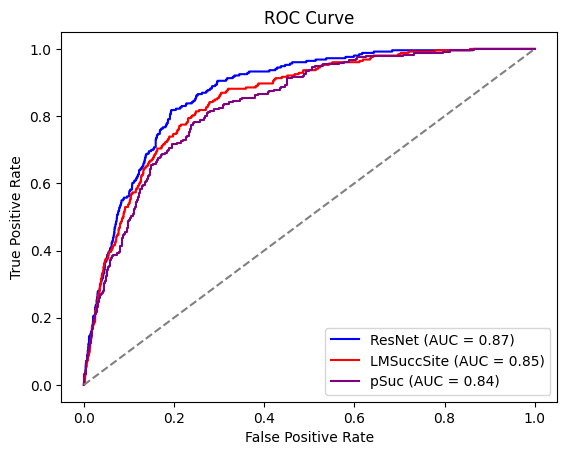

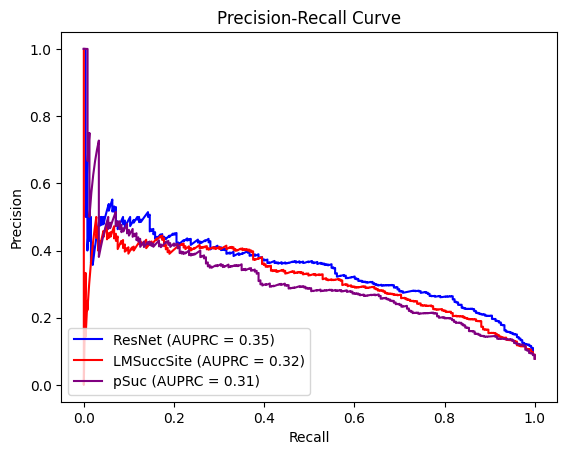

In [5]:
from keras.models import load_model

res_model = load_model('Thesis-Results/Models/Full Models/res_model.h5')
# res_pssm_model = load_model('Thesis-Results/Models/Full Models/res_pssm_model.h5')

y_prob_res = res_model.predict([X_test_num, X_test_embeddings])
y_pred_res = (y_prob_res > 0.5).astype(int)

# y_prob_res_pssm = res_pssm_model.predict([X_test_num, X_test_embeddings, X_test_PSSM])
# y_pred_res_pssm = (y_prob_res_pssm > 0.5).astype(int)

y_prob_LM = np.load('Thesis-Results/LM_y_prob.npy')
y_pred_LM = (y_prob_LM > 0.5).astype(int)

pSuc_df = pd.read_csv('Thesis-Results/pSuc_EDBM_result/proba.csv')
y_prob_pSuc = pSuc_df['probability'].values
y_pred_pSuc = (y_prob_pSuc > 0.5).astype(int)
y_true_pSuc = pSuc_df['label'].values

from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt

fpr_res, tpr_res, _ = roc_curve(y_test, y_prob_res)
# fpr_res_pssm, tpr_res_pssm, _ = roc_curve(y_test, y_prob_res_pssm)
fpr_lm, tpr_lm, _ = roc_curve(y_test, y_prob_LM)
fpr_pSuc, tpr_pSuc, _ = roc_curve(y_true_pSuc, y_prob_pSuc)
plt.figure()
plt.plot(fpr_res, tpr_res, color='blue', label='ResNet (AUC = %0.2f)' % roc_auc_score(y_test, y_prob_res))
# plt.plot(fpr_res_pssm, tpr_res_pssm, color='green', label='ResNet + PSSM (AUC = %0.2f)' % roc_auc_score(y_test, y_prob_res_pssm))
plt.plot(fpr_lm, tpr_lm, color='red', label='LMSuccSite (AUC = %0.2f)' % roc_auc_score(y_test, y_prob_LM))
plt.plot(fpr_pSuc, tpr_pSuc, color='purple', label='pSuc (AUC = %0.2f)' % roc_auc_score(y_true_pSuc, y_prob_pSuc))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.savefig('ROC_curve_test_set.pdf', format='pdf', bbox_inches='tight')
plt.show()

precision_res, recall_res, _ = precision_recall_curve(y_test, y_prob_res)
# precision_res_pssm, recall_res_pssm, _ = precision_recall_curve(y_test, y_prob_res_pssm)
precision_lm, recall_lm, _ = precision_recall_curve(y_test, y_prob_LM)
precision_pSuc, recall_pSuc, _ = precision_recall_curve(y_true_pSuc, y_prob_pSuc)
plt.figure()
plt.plot(recall_res, precision_res, color='blue', label='ResNet (AUPRC = %0.2f)' % average_precision_score(y_test, y_prob_res))
# plt.plot(recall_res_pssm, precision_res_pssm, color='green', label='ResNet + PSSM (AUPRC = %0.2f)' % average_precision_score(y_test, y_prob_res_pssm))
plt.plot(recall_lm, precision_lm, color='red', label='LMSuccSite (AUPRC = %0.2f)' % average_precision_score(y_test, y_prob_LM))
plt.plot(recall_pSuc, precision_pSuc, color='purple', label='pSuc (AUPRC = %0.2f)' % average_precision_score(y_true_pSuc, y_prob_pSuc))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.savefig('PR_curve_test_set.pdf', format='pdf', bbox_inches='tight')
plt.show()

t-SNE plots :

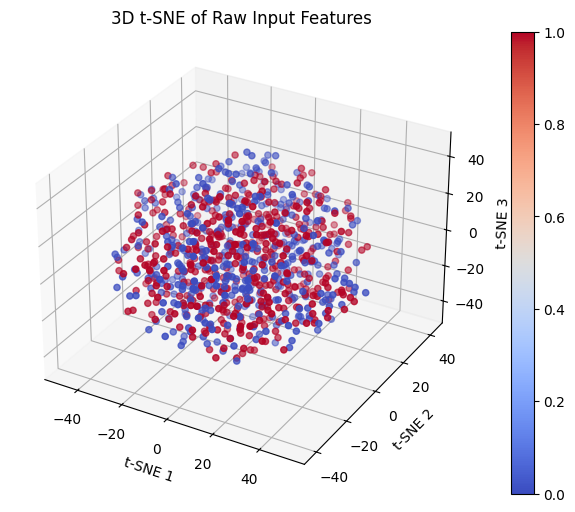

In [19]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # For 3D plots

def plot_tsne_3d(X, y, title):
    tsne = TSNE(n_components=3, random_state=4)
    X_tsne = tsne.fit_transform(X)

    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')
    
    scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2], c=y, cmap='coolwarm')
    fig.colorbar(scatter)
    
    ax.set_xlabel('t-SNE 1')
    ax.set_ylabel('t-SNE 2')
    ax.set_zlabel('t-SNE 3')
    
    plt.title(title)
    # plt.savefig(title + '.pdf', format='pdf', bbox_inches='tight')
    plt.show()

# Concatenate inputs for t-SNE before training
X_concat = np.concatenate([X_val_num, X_val_embeddings], axis=1)

# Plot t-SNE for the raw input features in 3D
plot_tsne_3d(X_concat, y_val, '3D t-SNE of Raw Input Features')


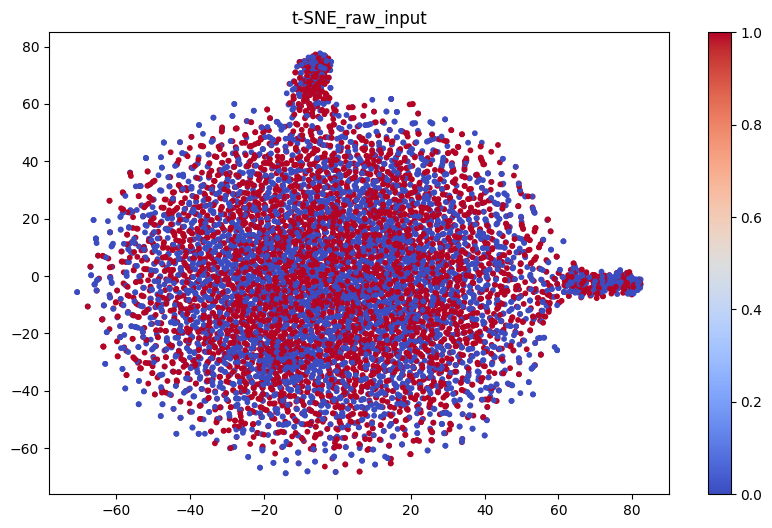

In [20]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


def plot_tsne(X, y, title):
    tsne = TSNE(n_components=2, random_state=4)
    X_tsne = tsne.fit_transform(X)

    plt.figure(figsize=(10, 6))
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='coolwarm', s=10)
    plt.colorbar()
    plt.title(title)
    plt.savefig(title+'.pdf', format='pdf', bbox_inches='tight')
    plt.show()
    

# Concatenate inputs for t-SNE before training
X_concat = np.concatenate([X_train_num, X_train_embeddings], axis=1)

# Plot t-SNE for the raw input features
plot_tsne(X_concat, y_train, 't-SNE_raw_input')


293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


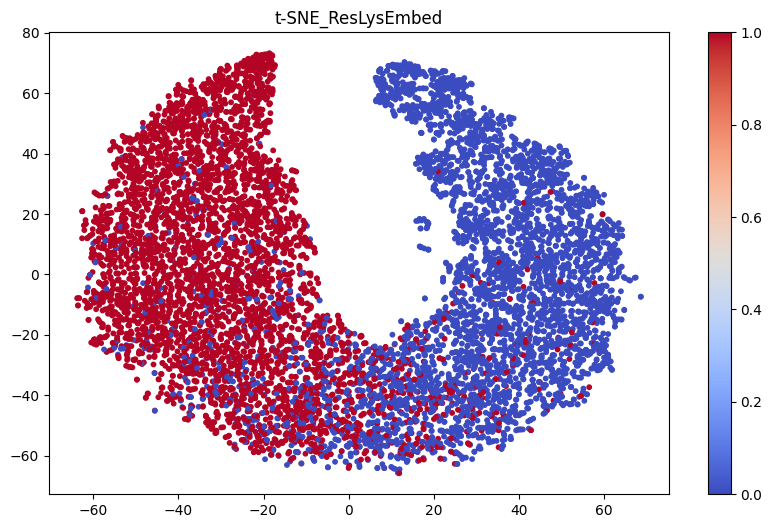

In [22]:
# Define a function to extract features from the penultimate layer
from keras.models import Model
from keras.models import load_model

simple_model = load_model('Thesis-Results/Models/Full Models/simple_model.h5')
inception_model = load_model('Thesis-Results/Models/Full Models/inception_model.h5')
res_model = load_model('Thesis-Results/Models/Full Models/res_model.h5')

def get_penultimate_layer_output(model, input_data):
    # Get the output of the second-to-last layer (penultimate)
    penultimate_layer_model = Model(inputs=model.input, outputs=model.layers[-3].output)
    return penultimate_layer_model.predict(input_data)

models = [ res_model]
# Extract features from the penultimate layer after training
for model in models:
    penultimate_output = get_penultimate_layer_output(model, [X_train_num, X_train_embeddings])

    # Plot t-SNE for the penultimate layer features
    plot_tsne(penultimate_output, y_train, f't-SNE_ResLysEmbed')


In [75]:
#20 randonly balanced test set
test = pd.read_csv('Embeddings/Prot_t5/test_t5_pssm.csv')
test_pos = test[test['label'] == 1]
test_neg = test[test['label'] == 0]

accuracies = []
mccs = []
aucs = []
auprcs = []
precisions = []
recalls = []
specificities = []
f1s = []

accuracies_pssm = []
mccs_pssm = []
aucs_pssm = []
auprcs_pssm = []
precisions_pssm = []
recalls_pssm = []
specificities_pssm = []
f1s_pssm = []

# Load the models
res_model = load_model('Thesis-Results/Models/Full Models/res_model.h5')
res_pssm_model = load_model('Thesis-Results/Models/Full Models/res_pssm_model.h5')

for i in range(20):
    test_neg = test_neg.sample(n=253, random_state=np.random.randint(0, 10000))

    test= pd.concat([test_pos, test_neg], axis=0)


    X_test_embeddings = test['embedding'].apply(lambda x: np.array([float(i) for i in x.strip('[]').split()]))
    X_test_PSSM = test['PSSM'].apply(lambda x: np.array([float(i) for i in x.strip("[]").split()]))
    X_test_PSSM = np.stack(X_test_PSSM.values)
    X_test_embeddings = np.stack(X_test_embeddings.values)
    scaler = PowerTransformer()
    X_test_PSSM = scaler.fit_transform(X_test_PSSM)
    X_test = test['sequence'].values
    y_test = test['label'].values

    # Create a dictionary to map amino acids to integers
    amino_acids = 'ACDEFGHIKLMNPQRSTVWY-'
    aa_to_int = {aa: i for i, aa in enumerate(amino_acids)}
    X_test_num = [[aa_to_int[aa] for aa in seq] for seq in X_test]
    X_test_num = np.array(X_test_num)

    # Evaluate the models
    acc, mcc, auc, auprc, precision, recall, specificity, f1 = evaluate_model(res_model, X_test_num, X_test_embeddings, y_val=y_test, print_metrics=False)
    accuracies.append(acc)
    mccs.append(mcc)
    aucs.append(auc)
    auprcs.append(auprc)
    precisions.append(precision)
    recalls.append(recall)
    specificities.append(specificity)
    f1s.append(f1)

    acc, mcc, auc, auprc, precision, recall, specificity, f1 = evaluate_model(res_pssm_model, X_test_num, X_test_embeddings, X_test_PSSM, y_val=y_test, print_metrics=False)
    accuracies_pssm.append(acc)
    mccs_pssm.append(mcc)
    aucs_pssm.append(auc)
    auprcs_pssm.append(auprc)
    precisions_pssm.append(precision)
    recalls_pssm.append(recall)
    specificities_pssm.append(specificity)
    f1s_pssm.append(f1)

print("Results for Residual Model:")
print(f'Accuracy: {np.mean(accuracies)} +- {np.std(accuracies)}')
print(f'MCC: {np.mean(mccs)} +- {np.std(mccs)}')
print(f'AUC: {np.mean(aucs)} +- {np.std(aucs)}')
print(f'AUPRC: {np.mean(auprcs)} +- {np.std(auprcs)}')
print(f'Precision: {np.mean(precisions)} +- {np.std(precisions)}')
print(f'Recall: {np.mean(recalls)} +- {np.std(recalls)}')
print(f'Specificity: {np.mean(specificities)} +- {np.std(specificities)}')
print(f'F1: {np.mean(f1s)} +- {np.std(f1s)}')

print("Results for Residual Model with PSSM:")
print(f'Accuracy: {np.mean(accuracies_pssm)} +- {np.std(accuracies_pssm)}')
print(f'MCC: {np.mean(mccs_pssm)} +- {np.std(mccs_pssm)}')
print(f'AUC: {np.mean(aucs_pssm)} +- {np.std(aucs_pssm)}')
print(f'AUPRC: {np.mean(auprcs_pssm)} +- {np.std(auprcs_pssm)}')
print(f'Precision: {np.mean(precisions_pssm)} +- {np.std(precisions_pssm)}')
print(f'Recall: {np.mean(recalls_pssm)} +- {np.std(recalls_pssm)}')
print(f'Specificity: {np.mean(specificities_pssm)} +- {np.std(specificities_pssm)}')
print(f'F1: {np.mean(f1s_pssm)} +- {np.std(f1s_pssm)}')





    

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━

In [9]:
#croos validation
from sklearn.model_selection import KFold
import numpy as np

# Define the number of splits for cross-validation
n_splits = 10
kf = KFold(n_splits=n_splits, random_state=4, shuffle=True)


# Perform cross-validation in a function
def cross_validate_model(model_name, X, X_pt5, y, kf, X_PSSM = None):
    set_seed(4)

    # Initialize lists to store the results
    y_preds = []
    y_trues = []
    y_probs = []

    accuracies = []
    mccs = []
    aucs = []
    auprcs = []
    precisions = []
    recalls = []
    specificities = []
    f1s = []
    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        X_train_pt5, X_val_pt5 = X_pt5[train_index], X_pt5[val_index]
        y_train, y_val = y[train_index], y[val_index]
        if X_PSSM is not None:
            X_train_PSSM, X_val_PSSM = X_PSSM[train_index], X_PSSM[val_index]

        # reinitialize the model
        if model_name == 'InceptLysEmbed':
            model = build_inception_model((33,), 1024)
        elif model_name == 'ResLysEmbed':
            model = build_resnet_model((33,), 1024)
        elif model_name == 'ConvLysEmbed':
            model = build_simple_model((33,), 1024)

        # Fit the model
        if X_PSSM is None:
            history = model.fit([X_train, X_train_pt5], y_train, epochs=40, batch_size=64, verbose=0,
                                validation_data=([X_val, X_val_pt5], y_val))
        else:
            history = model.fit([X_train, X_train_pt5, X_train_PSSM], y_train, epochs=40, batch_size=64, verbose=0,
                                validation_data=([X_val, X_val_pt5, X_val_PSSM], y_val))
                    
        y_true = y_val
        # Predict probabilities
        if X_PSSM is None:
            y_pred_probs = model.predict([X_val, X_val_pt5])
        else:
            y_pred_probs = model.predict([X_val, X_val_pt5, X_val_PSSM])

        # Convert probabilities to binary predictions
        y_pred = (y_pred_probs > 0.5).astype(int)

        # Append the results to the lists
        y_preds.append(y_pred)
        y_trues.append(y_true)
        y_probs.append(y_pred_probs)

        # Evaluate the model
        if X_PSSM is None:
            accuracy, mcc, auc, auprc, precision, recall, specificity, f1 = evaluate_model(model, X_val, X_val_pt5,
                                                                                            X_val_PSSM=None, y_val=y_val, print_metrics=False)
        else:
            accuracy, mcc, auc, auprc, precision, recall, specificity, f1 = evaluate_model(model, X_val, X_val_pt5,
                                                                                            X_val_PSSM, y_val, print_metrics=False)
        # Append the results to the lists
        accuracies.append(accuracy)
        mccs.append(mcc)
        aucs.append(auc)
        auprcs.append(auprc)
        precisions.append(precision)
        recalls.append(recall)
        specificities.append(specificity)
        f1s.append(f1)
    # Print the average results +- standard deviation
    print(f"Results for {model_name}:")
    print(f'Accuracy: {np.mean(accuracies)} +- {np.std(accuracies)}')
    print(f'MCC: {np.mean(mccs)} +- {np.std(mccs)}')
    print(f'AUC: {np.mean(aucs)} +- {np.std(aucs)}')
    print(f'AUPRC: {np.mean(auprcs)} +- {np.std(auprcs)}')
    print(f'Precision: {np.mean(precisions)} +- {np.std(precisions)}')
    print(f'Recall: {np.mean(recalls)} +- {np.std(recalls)}')
    print(f'Specificity: {np.mean(specificities)} +- {np.std(specificities)}')
    print(f'F1: {np.mean(f1s)} +- {np.std(f1s)}')

    plot_roc_pr(model_name, np.concatenate(y_trues), np.concatenate(y_probs), aucs, auprcs)

    return accuracies, mccs, aucs, auprcs, precisions, recalls, specificities, f1s

# Perform cross-validation for the 3 models
# cross_validate_model('simple_model', X_train_num, X_train_embeddings, y_train, kf)
# cross_validate_model('inception_model', X_train_num, X_train_embeddings, y_train, kf)
# cross_validate_model('res_model', X_train_num, X_train_embeddings, y_train, kf)





30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Results for ConvLysEmbed:
Accuracy: 0.7735923919889155 +- 0.010049518783826391
MCC: 0.5476183074115148 +- 0.02001179507159096
AUC: 0.845763202662195 +- 0.010476119131938062
AUPRC: 0.8280926093616442 +- 0.01489738

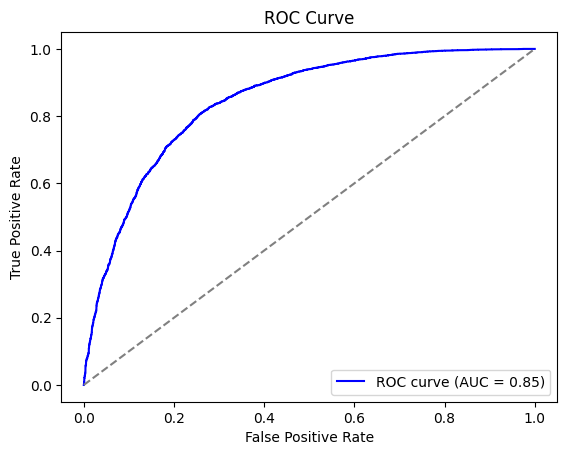

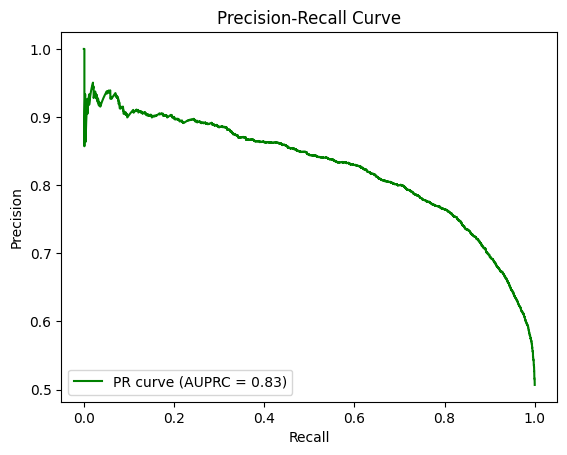

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Results for InceptLysEmbed:
Accuracy: 0.7752986980270014 +- 0.015631364635264003
MCC: 0.5524308186522063 +- 0.03180209991965783
AUC: 0.8499401043288604 +- 0.014678597782456025
AUPRC: 0.8311934569208292 +- 0.019392994298

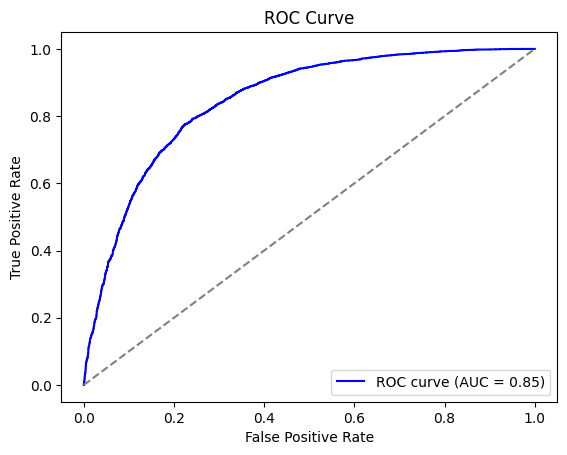

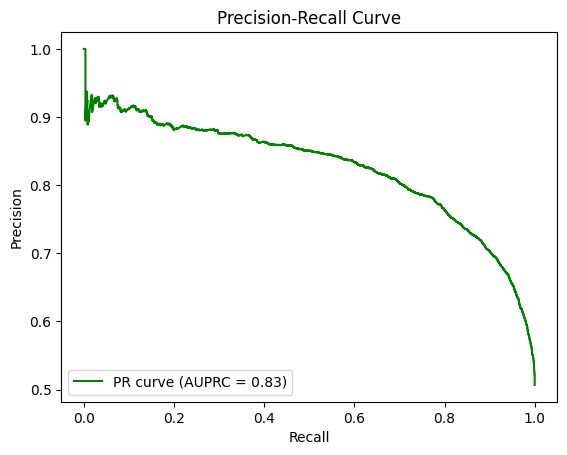

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Results for ResLysEmbed:
Accuracy: 0.7964859325081015 +- 0.013027444752855818
MCC: 0.5940958015013817 +- 0.027297546265819782
AUC: 0.870173008792437 +- 0.012676572999344578
AUPRC: 0.8521055179203285 +- 0.016474543515

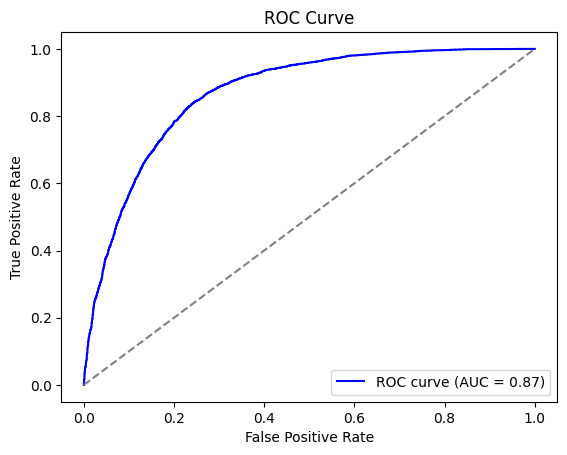

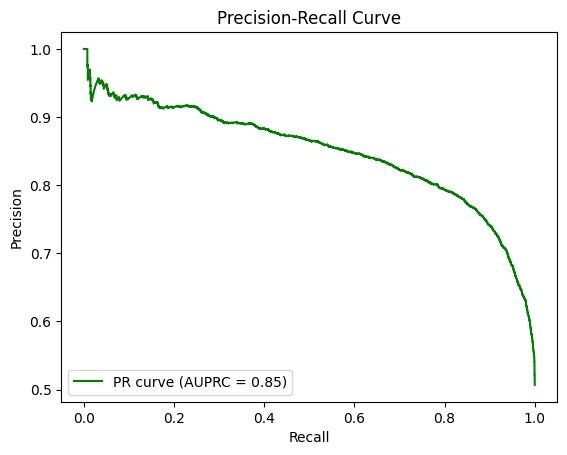

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Store all metrics for all models
cross_val_results = []

# Perform cross-validation for all models and collect results
for model_name in ['ConvLysEmbed', 'InceptLysEmbed', 'ResLysEmbed']:
    accuracies, mccs, aucs, auprcs, precisions, recalls, specificities, f1s = cross_validate_model(model_name, X_train_num, X_train_embeddings, y_train, kf)

    # Append the metrics to the results
    
    cross_val_results.extend([
        {'Model': model_name, 'Metric': 'Accuracy', 'Score': acc} for acc in accuracies])
    cross_val_results.extend([
        {'Model': model_name, 'Metric': 'MCC', 'Score': mcc} for mcc in mccs])
    cross_val_results.extend([
        {'Model': model_name, 'Metric': 'AUC', 'Score': auc} for auc in aucs])
    cross_val_results.extend([
        {'Model': model_name, 'Metric': 'AUPRC', 'Score': auprc} for auprc in auprcs])
    cross_val_results.extend([
        {'Model': model_name, 'Metric': 'Precision', 'Score': precision} for precision in precisions])
    cross_val_results.extend([
        {'Model': model_name, 'Metric': 'Recall', 'Score': recall} for recall in recalls])
    cross_val_results.extend([
        {'Model': model_name, 'Metric': 'Specificity', 'Score': specificity} for specificity in specificities])
    cross_val_results.extend([
        {'Model': model_name, 'Metric': 'F1-score', 'Score': f1} for f1 in f1s])

# Convert results to a DataFrame for visualization
results_df = pd.DataFrame(cross_val_results)

# Plotting boxplots and violin plots for the selected metrics
# selected_metrics = ['MCC', 'F1-score', 'AUC', 'AUPRC']
# for metric in selected_metrics:
#     metric_results = results_df[results_df['Metric'] == metric]

#     # Boxplot
#     plt.figure(figsize=(8, 6))
#     sns.boxplot(data=metric_results, x='Model', y='Score', palette='Set2')
#     plt.title(f'Boxplot of {metric} Across Models', fontsize=14)
#     plt.xlabel('Model', fontsize=12)
#     plt.ylabel(metric, fontsize=12)
#     plt.xticks(rotation=45)
#     plt.tight_layout()
#     # plt.savefig(f'Plots/Cross_Validation/{metric}_boxplot.pdf', format='pdf')
#     plt.show()

#     # Violin plot
#     plt.figure(figsize=(8, 6))
#     sns.violinplot(data=metric_results, x='Model', y='Score', palette='Set2', inner='quartile')
#     plt.title(f'Violin Plot of {metric} Across Models', fontsize=14)
#     plt.xlabel('Model', fontsize=12)
#     plt.ylabel(metric, fontsize=12)
#     plt.xticks(rotation=45)
#     plt.tight_layout()
#     # plt.savefig(f'Plots/Cross_Validation/{metric}_violinplot.pdf', format='pdf')
#     plt.show()


C:\Users\Admin\AppData\Local\Temp\ipykernel_6356\3601075042.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=metric_results, x='Model', y='Score', palette='Set2', inner='quartile', ax=axes[i])
C:\Users\Admin\AppData\Local\Temp\ipykernel_6356\3601075042.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=metric_results, x='Model', y='Score', palette='Set2', inner='quartile', ax=axes[i])
C:\Users\Admin\AppData\Local\Temp\ipykernel_6356\3601075042.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=metric_results, 

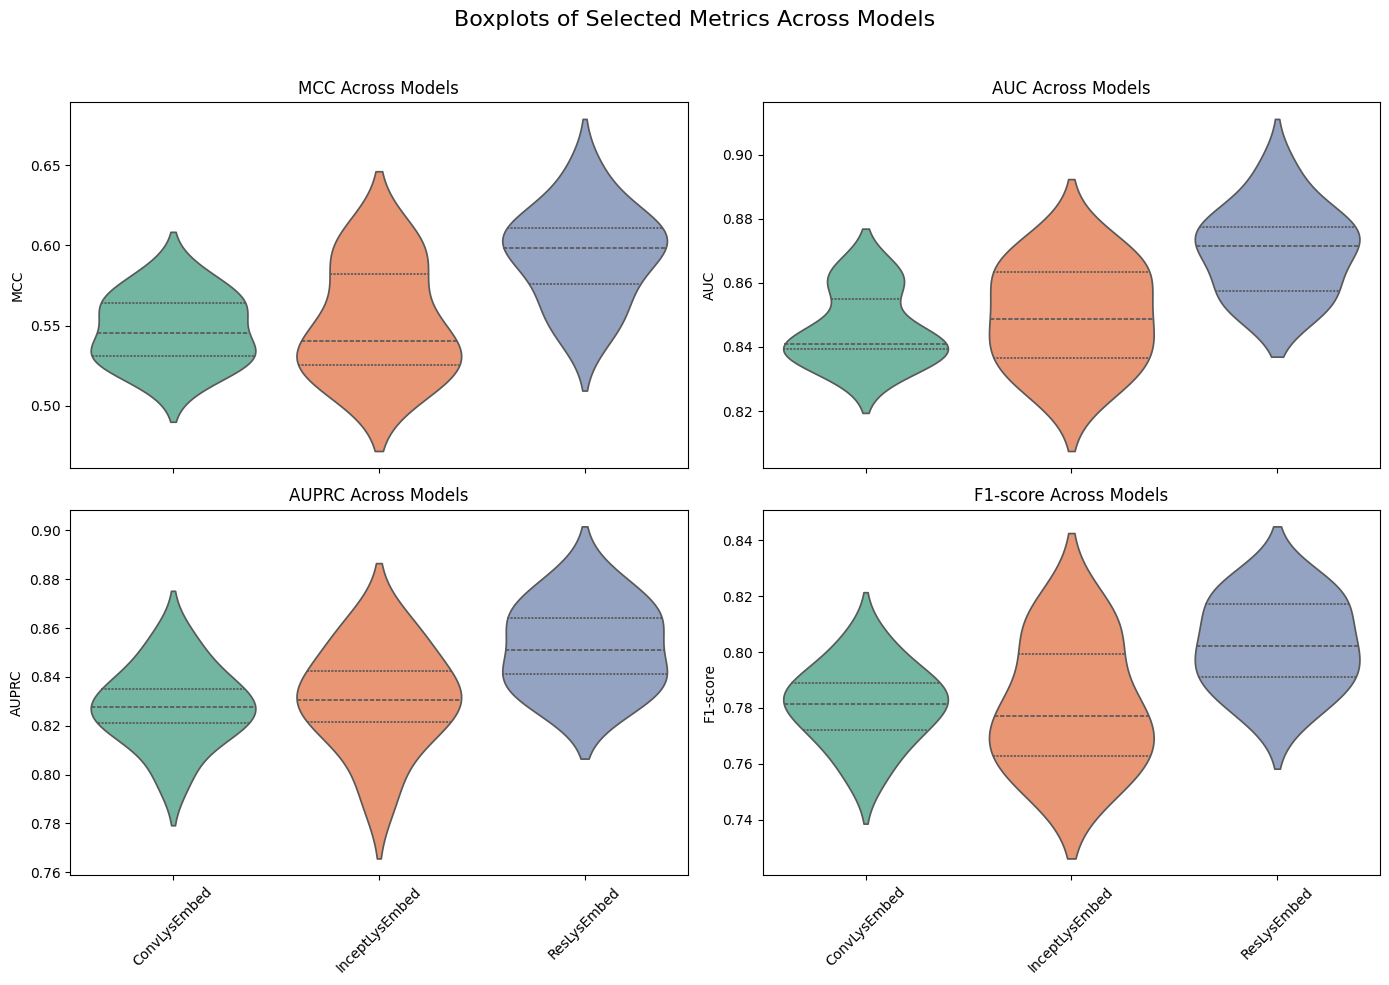

In [11]:
# Define the metrics and their order
selected_metrics = ['MCC', 'AUC', 'AUPRC', 'F1-score']

# Initialize the figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=False)
axes = axes.flatten()



# Plot each metric in its corresponding subplot
for i, metric in enumerate(selected_metrics):
    metric_results = results_df[results_df['Metric'] == metric]
    
    # sns.boxplot(data=metric_results, x='Model', y='Score', palette='Set2', ax=axes[i])
    sns.violinplot(data=metric_results, x='Model', y='Score', palette='Set2', inner='quartile', ax=axes[i])
    axes[i].set_title(f'{metric} Across Models', fontsize=12)
    axes[i].set_xlabel('')  # Remove x-axis labels for better alignment
    axes[i].set_ylabel(metric, fontsize=10)
    axes[i].tick_params(axis='x', rotation=45)

# Adjust layout for readability
fig.suptitle('Boxplots of Selected Metrics Across Models', fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('Plots/Model Selection/10_fold_CV_violin_subplot.pdf', format='pdf', bbox_inches='tight')
plt.show()

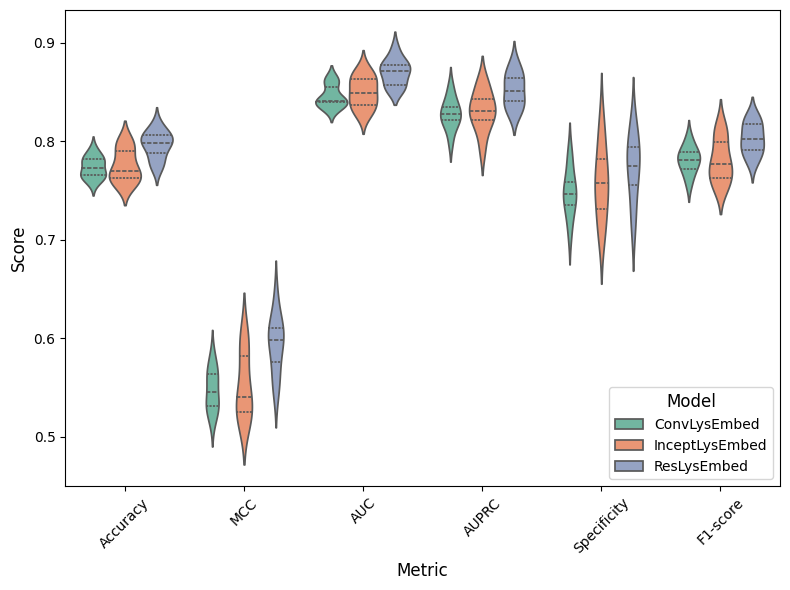

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the figure size
plt.figure(figsize=(8, 6))
selected_metrics = ['Accuracy', 'MCC', 'AUC', 'AUPRC', 'Specificity', 'F1-score']

results_df_selected = results_df[results_df['Metric'].isin(selected_metrics)]

# Create a boxplot with different metrics as hue
# sns.boxplot(data=results_df, x='Model', y='Score', hue='Metric', palette='Set2')
sns.violinplot(data=results_df_selected, x='Metric', y='Score', hue='Model', palette='Set2', inner='quartile')

# Customize the plot
# plt.title('Model Performance Metrics Across Validation Set Compositions', fontsize=16)
plt.xlabel('Metric', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Model', fontsize=10, title_fontsize=12)
plt.tight_layout()
plt.savefig('Plots/Model Selection/10_fold_CV_violinplot_new.pdf', format='pdf', bbox_inches='tight')
# Show the plot
plt.show()
